# undistort_fisheye
魚眼カメラモデルをベースにカメラキャリブレーションを行うNotebookです。ピンホールカメラモデルを用いた`undistort.ipynb`では補正後の画像端で変形が大きく、変形の少ない中央付近を切り出すことで対処しました。魚眼カメラモデルではより広い画角を利用できるため、Jetson Nano Mouseに搭載されたステレオカメラの画角の広さを活かすことができます。

## キャリブレーション手順
1. 事前に`undistort/undistort_data_collection.ipynb`を実行してキャリブレーション用画像を撮影します
1. `undistort/chess_images`ディレクトリに撮影したキャリブレーション画像があることを確認します
1. セルを順に実行し歪み補正された画像が作成されれば正常にキャリブレーションが完了しています

## 魚眼カメラモデルとピンホールカメラモデルの違い
魚眼カメラモデルはピンホールカメラモデルと比較してより大きな歪みを補正することができます。Jetson Nano Mouseに搭載されているような広角なカメラは歪みが大きいため、ピンホールカメラモデルでキャリブレーションを行っても画面端の歪みが補正しきれません。そのためカメラの画角が広いにもかかわらず、歪みの少ない中央付近の領域しかキャリブレーションできません。魚眼カメラモデルをキャリブレーションに用いることでより広い画角の歪み補正された画像を得られます。是非実際にピンホールカメラモデルを用いた`undistort/undistort.ipynb`と比較してみてください。


<details><summary><h4> ✍ 魚眼カメラモデルについてくわしくはこちらをクリックして解説をご覧ください</h4></summary><div>

はじめに撮影対象を半球上に投影する形でモデリングを行います。

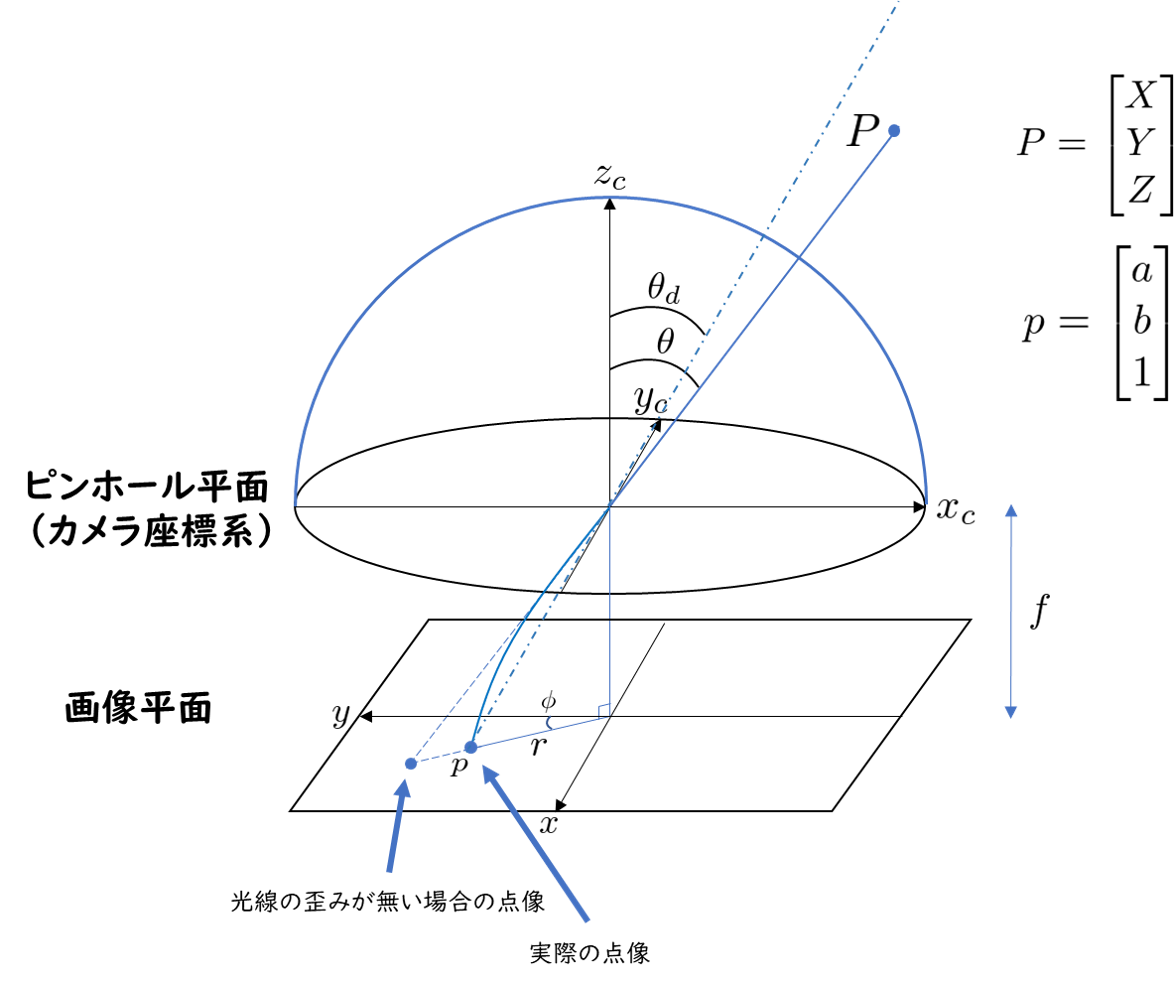

上図の$P$は撮影点のカメラ座標上での位置、$p$は画像平面における撮影点の位置を示しています。

図中のrの大きさはカメラの設計によって異なります。等距離射影方式($ r = f \cdot \theta$)，等立体角射影方式（$ r= f \sin(\frac{\theta}{2}$))など複数のモデルが存在します。   
しかし実際に使用する魚眼カメラがどのモデルに当てはまるものであるかを確認することは困難です。  
そこでOpenCVではレンズの歪みモデルにKannalaの提案した次の多項式を用いています。  
（ http://www.ee.oulu.fi/~jkannala/publications/tpami2006.pdf ）

\begin{equation}
r = \theta(1+k_1 \theta ^2 + k_2 \theta ^4 + k_3 \theta ^6 + k_4 \theta ^8)
\end{equation}

焦点距離$f$が消えてしまっているように見えますが、これは正規化画像座標系を用いれば$f=1$となるため問題ありません。

ここで画像座標平面における点像の位置を計算すると

\begin{equation}
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
r(\theta)
\begin{bmatrix}
cos\phi \\
sin\phi
\end{bmatrix}
\end{equation}
となります。

【補足】
ここで
\begin{equation}
\theta _d = \theta(1+k_1 \theta ^2 + k_2 \theta ^4 + k_3 \theta ^6 + k_4 \theta ^8)
\end{equation}
とおくと、

\begin{equation}
\begin{bmatrix}
x \\
y
\end{bmatrix}
=
r(\theta_d)
\begin{bmatrix}
cos\phi \\
sin\phi
\end{bmatrix}
=
\theta_d
\begin{bmatrix}
\frac{a}{r} \\
\frac{b}{r}
\end{bmatrix}
\end{equation}
と置け、$\phi$が式に出てこない形になります。OpenCVではこちらで記述しているようです。

あとは通常のカメラと同様、正規化画像座標の点を内部パラメータを用いてpixel単位の画像座標系に変換するだけです。

\begin{equation}
\begin{bmatrix}
u \\
v \\
1
\end{bmatrix}
=
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
\end{equation}

図中の$r$と$\theta$は以下の式で計算出来ます。

\begin{align}
r^2 = a^2 + b^2 \\
r = tan(\theta)
\end{align}

* 参考: 
    * [OpenCV: Camera Calibration](https://docs.opencv.org/master/dc/dbb/tutorial_py_calibration.html)
    * [OpenCV: Fisheye camera model](https://docs.opencv.org/4.3.0/db/d58/group__calib3d__fisheye.html)
    * [魚眼カメラのキャリブレーション ~ レンズモデル - Daily Tech Blog](https://daily-tech.hatenablog.com/entry/2019/06/05/153145)

</div></details>

## カメラキャリブレーション
下記に続くセルを順に実行していきます。まずは必要なPythonモジュールを読み込みます。

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
np.set_printoptions(threshold=5)

キャリブレーションを行うカメラを指定します。右カメラをキャリブレーションする際は`camera_position`に文字列`right`を代入してください。左カメラの場合は`left`を代入します。セルを実行するとキャリブレーション用画像のファイルパスが一覧になって表示されることをご確認ください。

In [2]:
camera_position = "left"

if camera_position == "left":
    imgs_dir = sorted(glob.glob(os.path.join('chess_images', '*left*.jpg')))
elif camera_position == "right":
    imgs_dir = sorted(glob.glob(os.path.join('chess_images', '*right*.jpg')))
else:
    print("camera_positionの入力が間違っています．")
print(imgs_dir)

['chess_images/326b532c-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/3b0e51aa-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/427db3c2-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/4554e08e-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/47d399f4-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/4a22d6e8-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/4e3a13ae-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/4fd6696a-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/6e01757e-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/75c669f4-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/7bed5c5c-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/829f3250-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/84d6cdda-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/8670f42c-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/883ec4a0-b946-11eb-8745-16f63a1aa8c9_right.jpg', 'chess_images/9008a052-b946-11eb-8745-16f63a1aa8c9_rig

チェスボードの角(格子点)の数とマスの辺の長さを`camera_config.xml`から読み込みます。

In [3]:
tree = ET.parse("../camera_param/camera_config.xml")
root = tree.getroot()
v_num = int(root.find("board_param").find("v_num").text) # 横方向の格子点数
h_num = int(root.find("board_param").find("h_num").text) # 縦方向の格子点数
chess_size = float(root.find("board_param").find("chess_size").text) # チェスボード１マスあたりの長さ[mm]

キャリブレーションに必要なobject pointsを作成します。object pointsはワールド座標系におけるチェスボードの格子点の位置です。今回は歪み補正のみ行うためobject pointsの大きさは正規化されています。撮影対象の奥行きを計測する`undistort/undistort_fisheye_stereo.ipynb`では現実の距離が必要になるのでobject pointsにチェスボードのマスの大きさが反映されています。

In [4]:
object_point = np.zeros((1, v_num*h_num, 3), np.float32) # fisheye.calibrate()用に一つ次元を増やす
object_point[0, :,:2] = np.mgrid[0:v_num, 0:h_num].T.reshape(-1,2)

object_points = [] # 上述したobject_pointの集まり（3次元ベクトルのリスト）
img_points = [] # 画像座標上での格子点（2次元空間）の集まり（2次元ベクトルのリスト）

各キャリブレーション用画像からチェスボードの格子点を検出し、`img_points`に保存します。`img_points`の位置関係からカメラの歪み具合が推定できます。`img_points`が二次元画像上の格子点の位置を保存し、`object_points`が三次元空間上の格子点の位置を保存しています。

In [5]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # 反復アルゴリズムの終了基準の指定
imgs = [] # 画像表示用

for img_dir in imgs_dir:
    img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    ret, corners = \
        cv2.findChessboardCorners(
            img,
            (v_num, h_num),
            None,
            cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE+cv2.CALIB_CB_FAST_CHECK) # 画像から格子点を探す（ピクセル単位）
    if ret == True: # 検出に成功した画像の検出結果を保存
        object_points.append(object_point)
        corners_subpix = cv2.cornerSubPix(img, corners, (11, 11), (-1, -1), criteria) # サブピクセル単位で画像座標上での格子点を再計算
        img_points.append(corners_subpix)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        img = cv2.drawChessboardCorners(img, (v_num,h_num), corners_subpix, ret) # 検出した格子点の描画
        imgs.append(img)

チェスボードの格子点が正しく検出されているか確認するため、検出結果を表示する関数を作成します。

In [6]:
def gridShow(imgs):
    img_num = len(imgs)
    col = 3
    row = np.ceil(img_num / col)
    
    fig = plt.figure(figsize=(18, 4*row))
    idx = 0 # 画像のインデックス
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axis = fig.add_subplot(row, col, idx + 1)
        axis.imshow(img)
        idx = idx + 1

チェスボードの格子点の検出結果を表示します。格子点が色のついた線で結ばれていれば正常に検出されています。

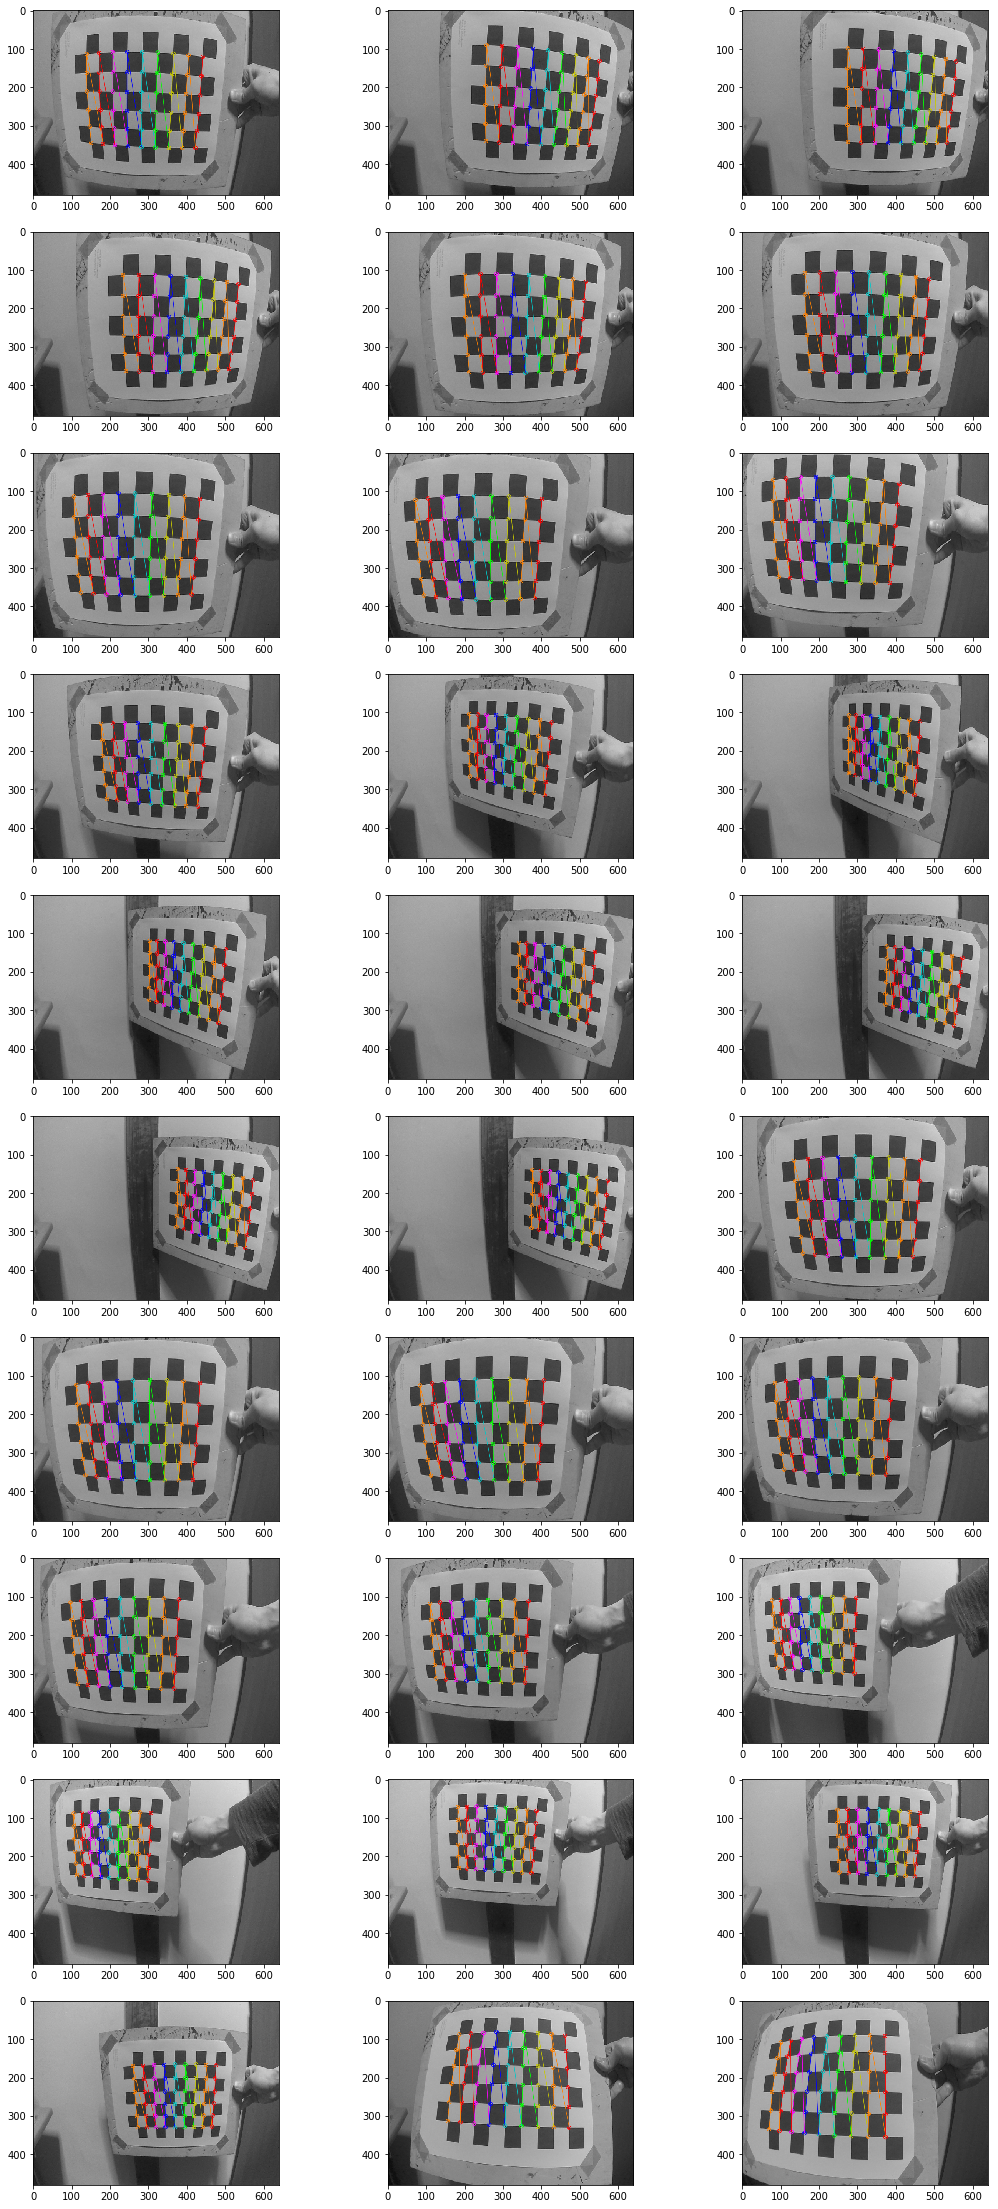

In [7]:
gridShow(imgs)

キャリブレーション用画像からカメラモデルを推定します。このカメラモデルにカメラの歪み具合などの情報が含まれており、歪み補正に使用します。
* カメラモデルのパラメータ
    * `rms`: 再投影誤差(root mean square)
    * `mtx`: カメラの内部パラメータ行列
    * `dist`: 歪み係数のベクトル(ここではk_1, k_2, p_1, p_2)
    * `rvecs`: 各視点における回転ベクトル（ロドリゲス形式）
    * `tvecs`: 各視点における並進ベクトル（x, y ,z）

In [8]:
h, w = img.shape[:2]

rms, mtx, dist, rvecs, tvecs = \
    cv2.fisheye.calibrate(
        object_points,
        img_points,
        (w, h),
        None,
        None,
        None,
        None,
        cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW,
        criteria
    )

推定した歪み具合から逆算し、歪みを補正したカメラモデルを作ります。

In [9]:
newmtx = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(mtx, dist, (w,h), None, balance=1.0)

In [10]:
print("rm:\n{}\n".format(rms))
print("mtx:\n{}\n".format(mtx))
print("dist:\n{}\n".format(dist))
print("newmtx:\n{}\n".format(newmtx))

rmt: 再投影誤差(root mean square)
0.31848345434658987
mtx: カメラの内部パラメータ行列
[[393.22161182   0.         350.79683842]
 [  0.         524.20980914 269.76926714]
 [  0.           0.           1.        ]]
dist: 歪み係数のベクトル(ここではk_1, k_2, p_1, p_2)
[[-0.04535501]
 [ 0.08700622]
 [-0.2168255 ]
 [ 0.18467129]]
newmtx: 歪み補正されたカメラの内部パラメータ行列
[[271.31596462   0.         346.24090427]
 [  0.         361.69550644 266.9930539 ]
 [  0.           0.           1.        ]]


画像のキャリブレーションを行います。左がキャリブレーション前、右がキャリブレーション後です。チェスボードのマス目がまっすぐになっていれば正常にキャリブレーションがされています。

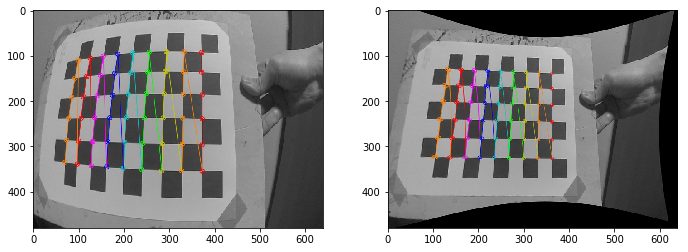

In [11]:
map1, map2 = cv2.fisheye.initUndistortRectifyMap(mtx, dist, None, newmtx, (w, h), cv2.CV_16SC2)
undistorted_img = cv2.remap(img, map1, map2, cv2.INTER_CUBIC, cv2.BORDER_CONSTANT)

gridShow([img, undistorted_img])

作成したカメラモデルを保存します。保存したカメラモデルはステレオカメラキャリブレーションの際に初期値として使用されます。

In [12]:
if camera_position == "left":
    np.savez('../camera_param/camera_param_fisheye_l.npz',
        mtx_l=mtx,
        dist_l=dist
    )
else:
    np.savez('../camera_param/camera_param_fisheye_r.npz',
        mtx_r=mtx,
        dist_r=dist
    )

## まとめ
魚眼カメラモデルをベースにカメラキャリブレーションを行い、画像の歪み補正をしました。次のステップの`undistort_fisheye_stereo.ipynb`では、作成したカメラモデルを用いてカメラと撮影対象の距離を推定します。